# Stochastic volatility

In this notebook we'll build a stochastic volatility model and try to predict the future market. Begin by installing yfinance

In [1]:
!pip install yfinance seaborn

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Fetch the S&P500 data from yfinance

In [2]:
from yfinance import Ticker
import seaborn as sns

sns.set_palette("deep")

ticker = Ticker("^GSPC")
df = ticker.history(period="max")

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


Alright, lot's of data. Let's resample to monthly and calculate log returns

<Axes: xlabel='Date'>

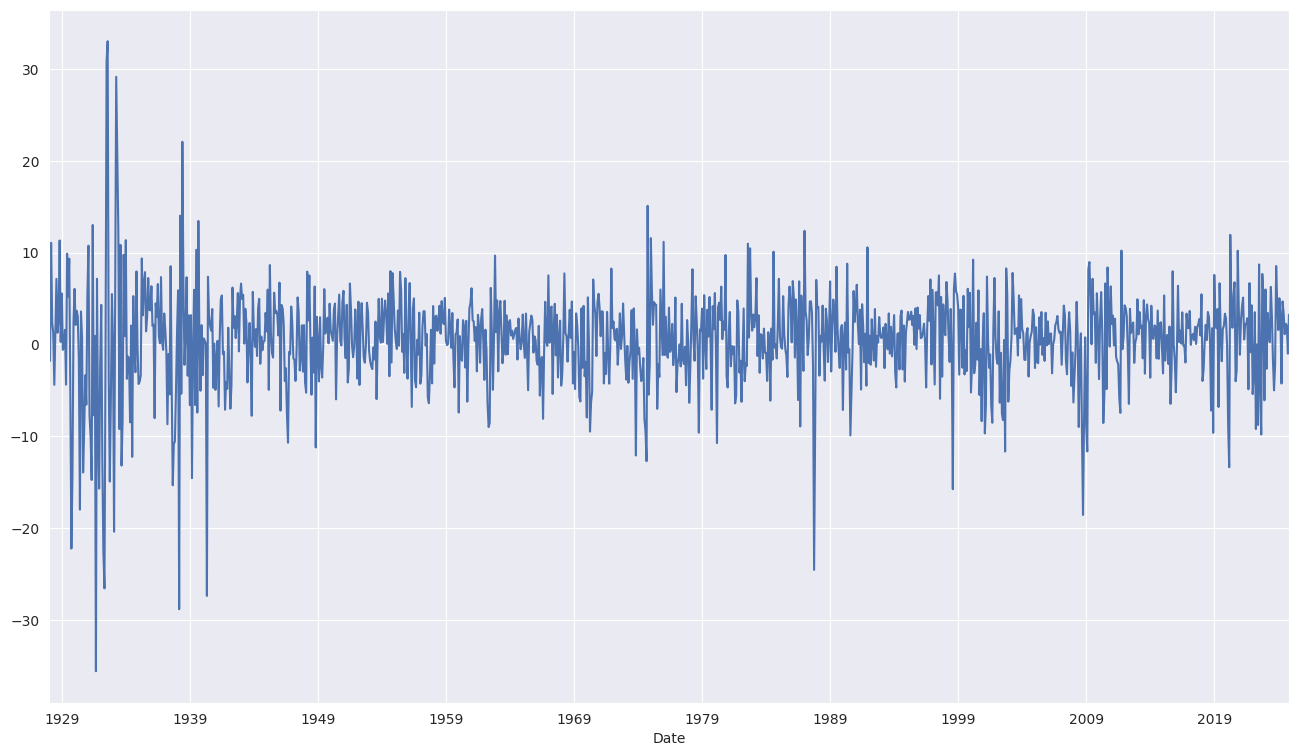

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

log_returns = df["Close"].resample("ME").last().pipe(np.log).diff().iloc[1:] * 100.0

log_returns.plot()

Really long data series, fun stuff! Let's consider how we should model this. We'll begin with plotting the partial autocorrelation function

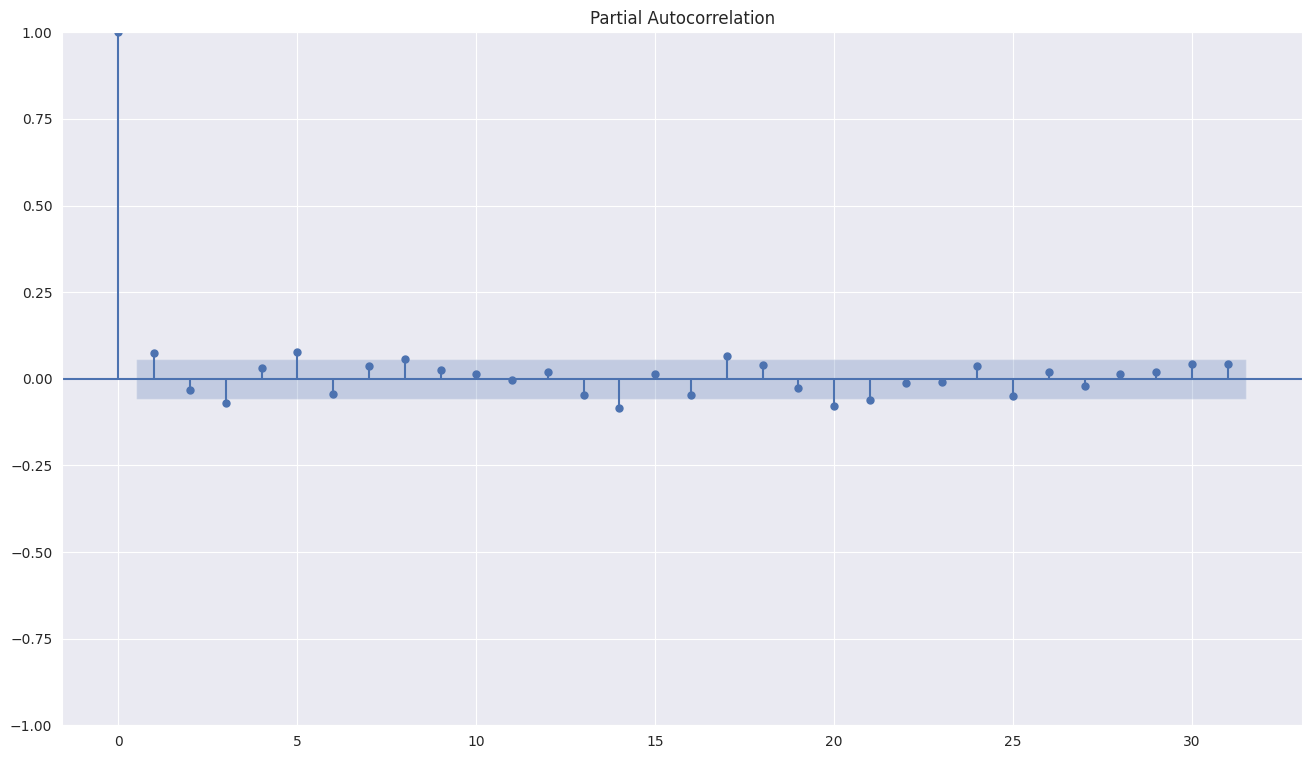

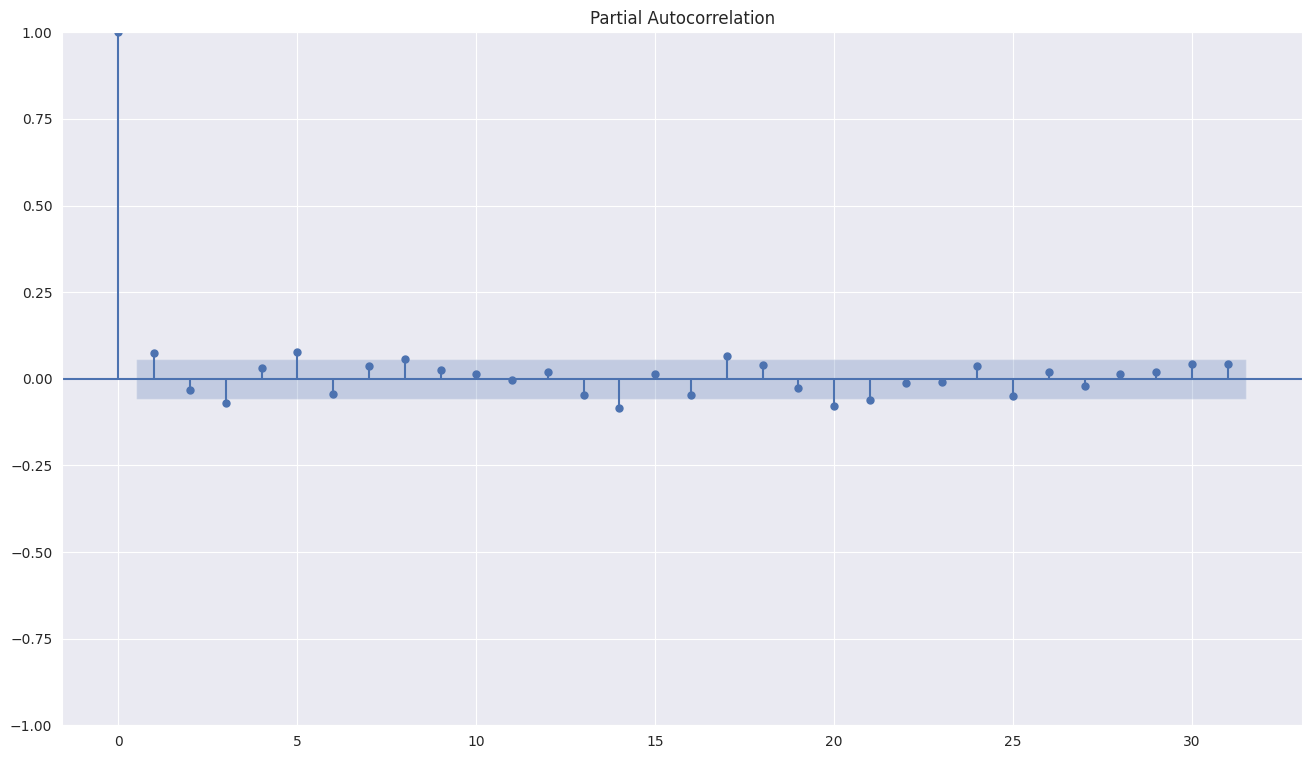

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(log_returns)

And also the partial autocorrelation of the absolute

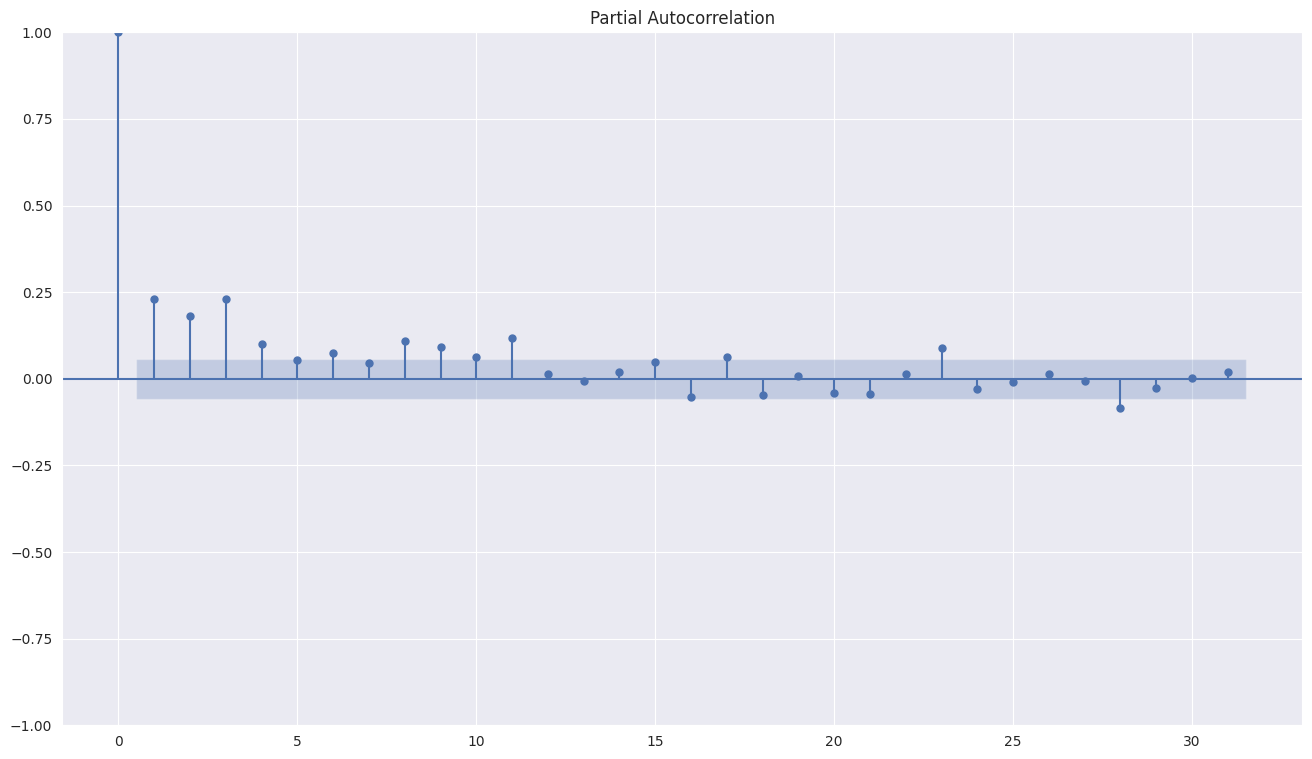

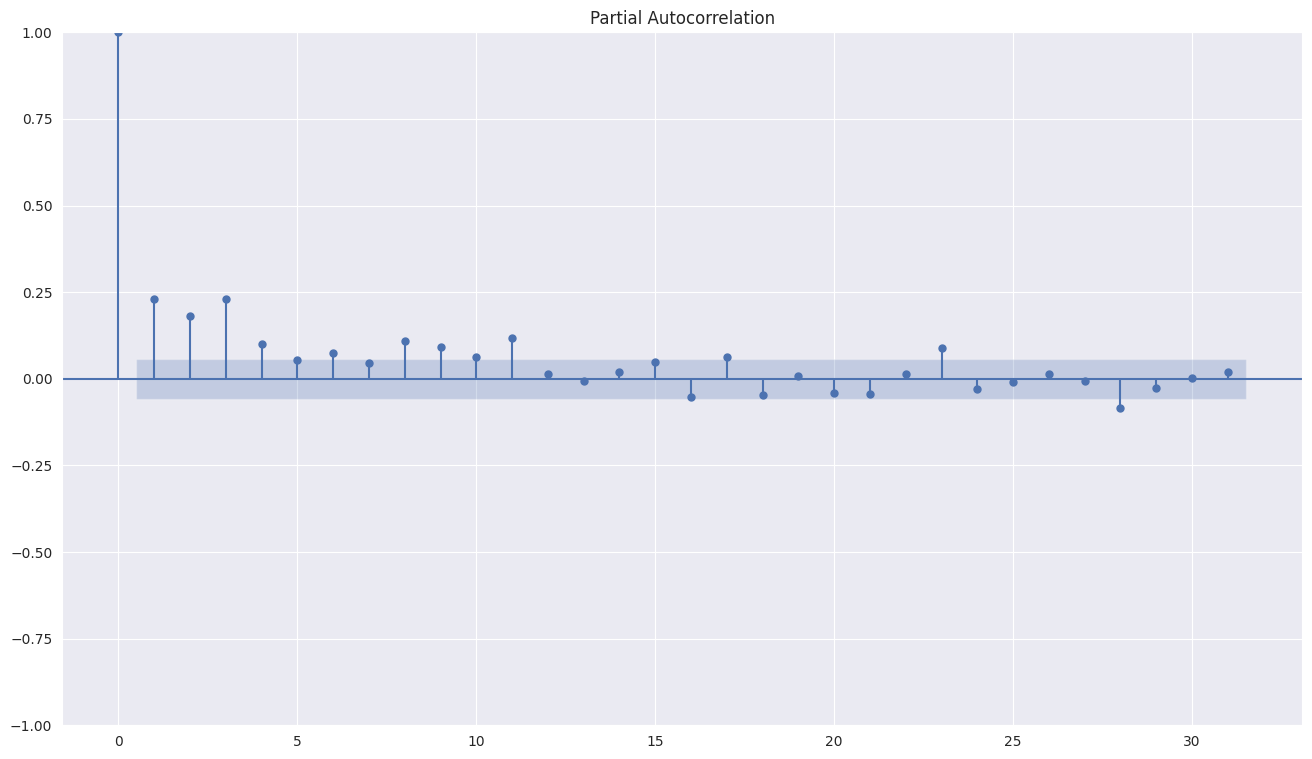

In [5]:
plot_pacf(np.abs(log_returns))

Alright, there seems to be (weak) autocorrelation on some of the lags when looking at raw, and high persistance when looking at absolute values supporting the claims of volatility clustering. The raw series also seems to exhibit a sine like pattern in the autocorrelation perhaps indicating a business cycle. To keep things simple, we'll do the following

1. Mean reverting stochastic volatility
2. Returns are autocorrelated with the last value

Translating this to a model yields

In [10]:
from numpyro.infer import NUTS
from xarray import DataArray
from functools import partial
from numpyro.contrib.control_flow import scan
from numpyro_sts import AutoRegressive
from numpyro.distributions.transforms import SigmoidTransform
from numpyro.distributions import Normal, TransformedDistribution, TruncatedNormal, LogNormal, HalfNormal
import numpyro
from skyro import BaseNumpyroForecaster
import jax.numpy as jnp


numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)


def body_fn(state_t, x_tp1, phi, mu):
    vol_tp1 = x_tp1
    y_t = state_t

    y_tp1 = numpyro.sample("y", Normal(mu + phi * (y_t - mu), vol_tp1))

    return y_tp1, y_tp1


class StochasticVolatilityModel(BaseNumpyroForecaster):
    """
    Implements a stochastic volatility model with auto-correlation and a business cycle.
    """

    names_in_trace = ["y"]

    def build_kernel(self, **kwargs):
        dense_mass = [("volatility/mu", "volatility/phi", "volatility/sigma")]
        return NUTS(self.build_model, dense_mass=dense_mass)

    def build_model(self, y, length: int, X=None, future: int = 0, **kwargs):
        with numpyro.handlers.scope(prefix="volatility"):
            mu = numpyro.sample("mu", Normal())
            phi = numpyro.sample("phi", TransformedDistribution(Normal(), SigmoidTransform()))
            sigma = numpyro.sample("sigma", LogNormal())

            x_0 = mu + sigma / jnp.sqrt(1.0 - phi**2.0) * numpyro.sample("eps_0", Normal())
            log_volatility_model = AutoRegressive(length, phi, sigma, 1, mu=mu, initial_value=x_0)

            log_volatility = numpyro.sample("x", log_volatility_model)

            if future > 0:
                future_log_volatility = numpyro.sample("x_future", log_volatility_model.predict(future, log_volatility[-1]))
                log_volatility = jnp.concat([log_volatility, future_log_volatility], axis=-2)

            volatility = jnp.exp(log_volatility).squeeze(-1)

        # observed
        mu = numpyro.sample("mu", Normal())
        phi = numpyro.sample("phi", TruncatedNormal(low=-1.0, high=1.0))

        y_0 = mu + jnp.exp(x_0) / jnp.sqrt(1.0 - phi ** 2.0) * numpyro.sample("eps_0", Normal())
        fun = partial(body_fn, phi=phi, mu=mu)

        with numpyro.handlers.condition(data={"y": jnp.array(y) if y is not None else None}):
            _, y = scan(fun, y_0, volatility)

        return

    def format_output(self, x, horizon):
        return DataArray(
            x["y"],
            dims=["draw", "time"],
            coords={"time": horizon.to_numpy()},
            name="y",
        )


And fitting the model yields

In [11]:
model = StochasticVolatilityModel(num_warmup=5_000, num_samples=1_000, num_chains=4, chain_method="parallel", progress_bar=True, seed=1234)
model.fit(log_returns)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

StochasticVolatilityModel(num_chains=4, num_samples=1000, num_warmup=5000,
                          seed=1234)

Let's plot the posteriors

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'phi'}>,
        <Axes: title={'center': 'volatility/mu'}>],
       [<Axes: title={'center': 'volatility/phi'}>,
        <Axes: title={'center': 'volatility/sigma'}>, <Axes: >]],
      dtype=object)

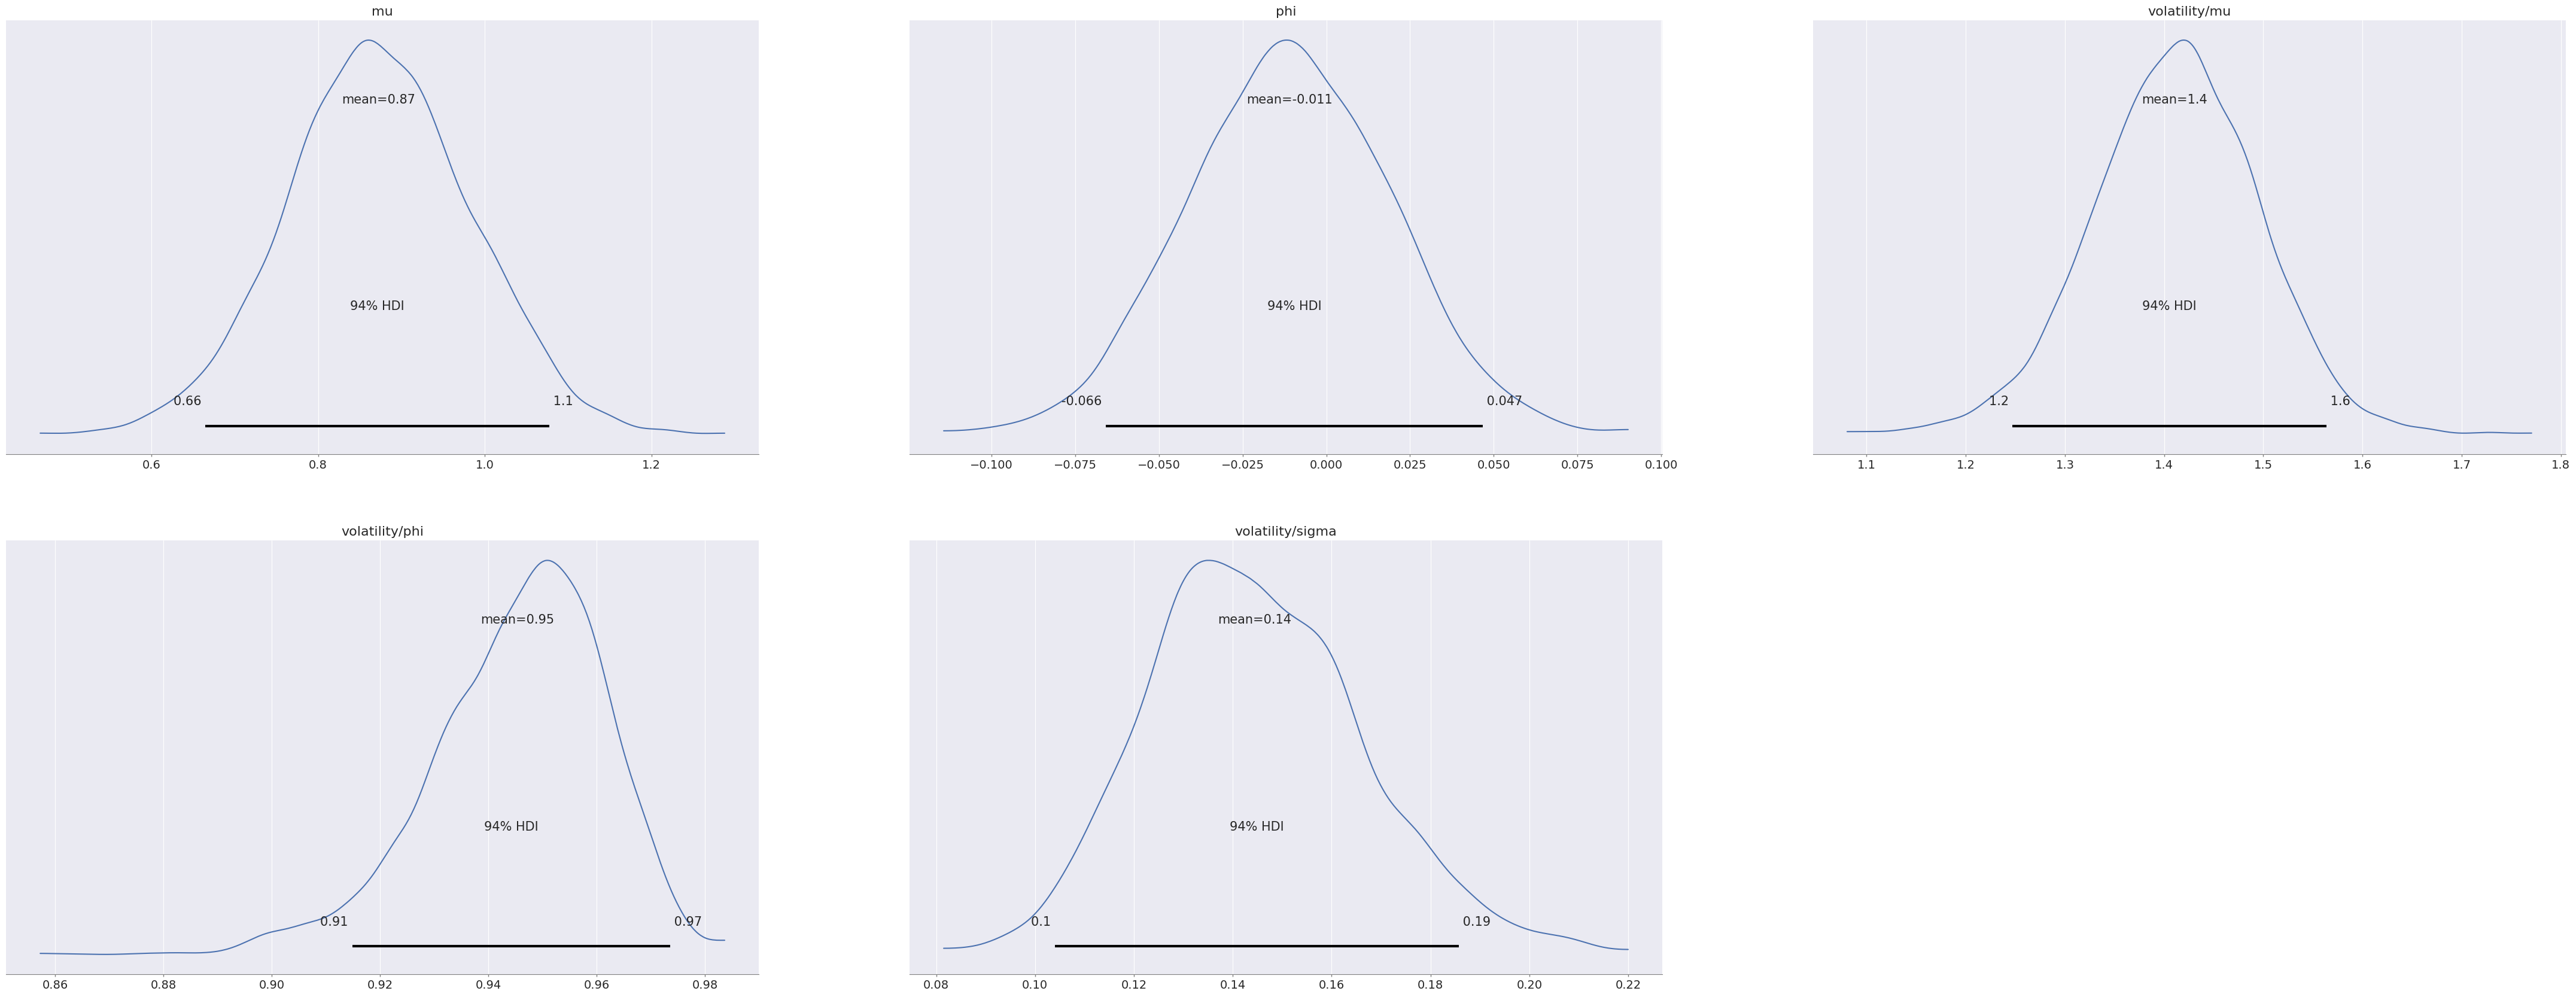

In [12]:
import arviz as az

idata = model.to_idata()
az.plot_posterior(idata.posterior, var_names=["phi", "mu", "sigma"], filter_vars="like")

Let's look at volatility

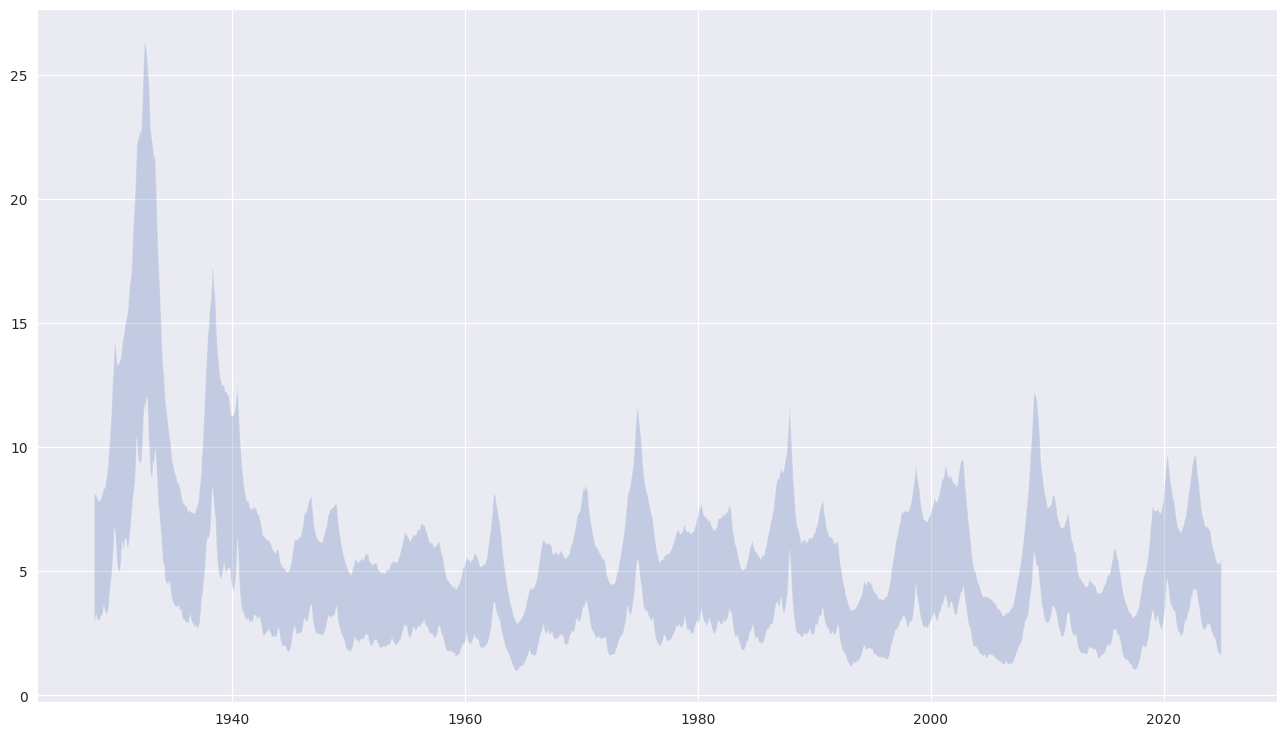

In [13]:
volatility = np.exp(idata.posterior["volatility/x"])

low, high = volatility.quantile([0.025, 0.975], dim=["chain", "draw"])

plt.fill_between(log_returns.index, low.squeeze(axis=-1), high.squeeze(axis=-1), alpha=0.25)

Let's also do some PPC to check the model's capabilities

/home/tingiskhan/miniconda3/envs/skyro/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:957: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)


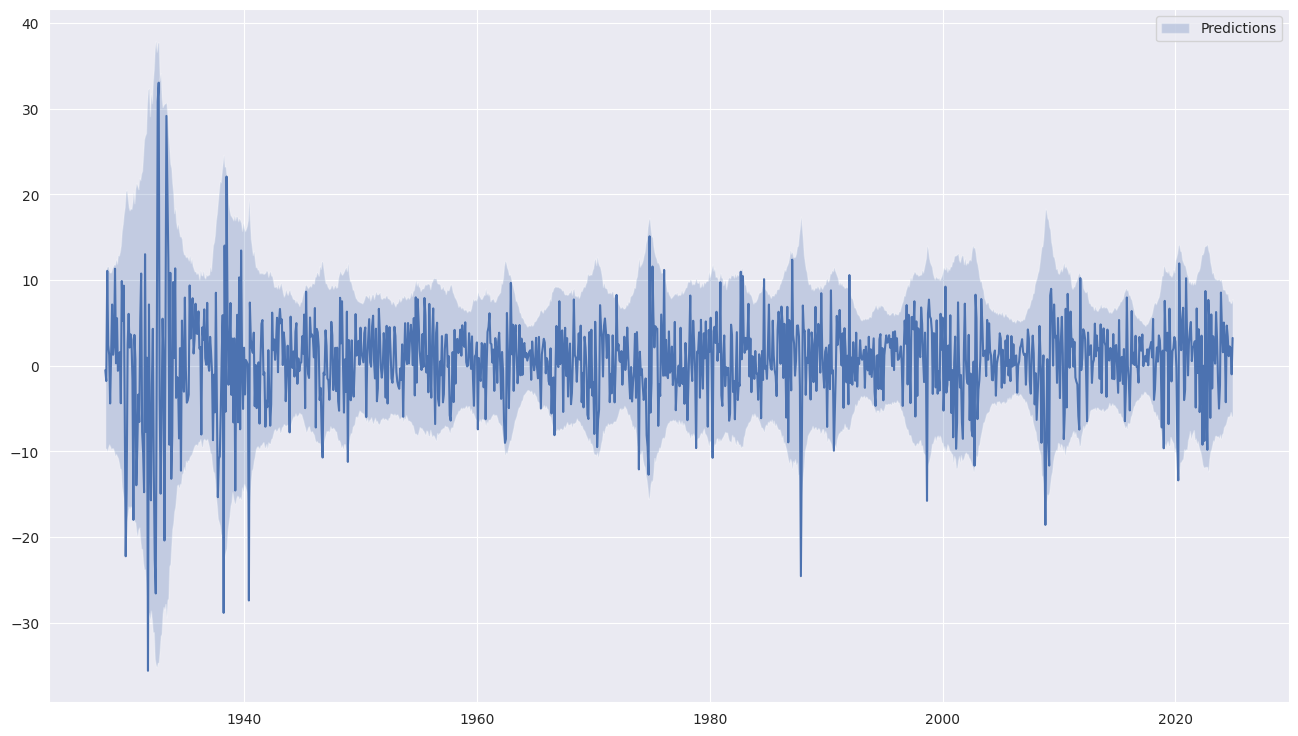

In [18]:
with model.ppc():
    in_sample = model.predict_quantiles(log_returns.index, alpha=[0.025, 0.975])

fig, ax = plt.subplots()

ax.fill_between(in_sample.index, in_sample.iloc[:, 0], in_sample.iloc[:, 1], alpha=0.25, label="Predictions")
ax.plot(log_returns.index, log_returns.values)

ax.legend()

Looking good! Let's predict 12 months into the future

/home/tingiskhan/miniconda3/envs/skyro/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:957: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)


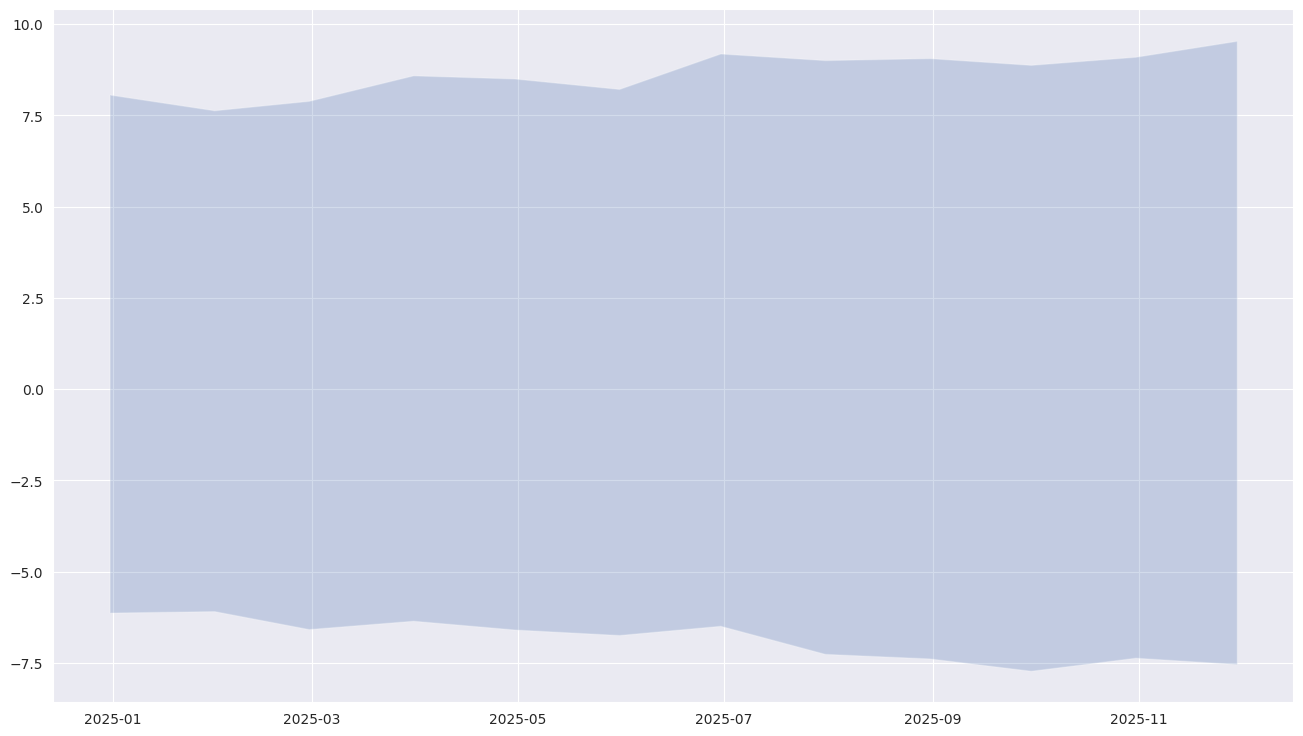

In [17]:
future = np.arange(1, 13)
predictions = model.predict_proba(future)

quantiles = predictions.quantile([0.025, 0.975])

plt.fill_between(quantiles.index, quantiles.iloc[:, 0], quantiles.iloc[:, 1], alpha=0.25)

The above results are pretty uninformative, but the main point of this notebook was to demonstrate how to use the library rather than providing a model for you to make money!